In [1]:
import jax.numpy as np
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


In [2]:
with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb = lamb.astype(np.float64)
sigma = sigma.astype(np.float64)
ind_sx = 81
ind_sy = 182
lamb_sigma = np.hstack([lamb,sigma])

In [3]:
## Doing with an object 'model' I still like that 
def eval_Cauchy(lambx,lamby, model):
    I1 = lambx**2+lamby**2+(1./(lambx*lamby)**2)
    I2 = lambx**2*lamby**2 + lambx**2*(1./(lambx*lamby)**2) + lamby**2*(1./(lambx*lamby)**2) 
    I4a = lambx**2
    I4s = lamby**2
    I1 = (I1-3)
    I2 = (I2-3)
    I4a = (I4a-1)
    I4s = (I4s-1)
    
    Psi1 = model.Psi1(I1)
    Psi2 = model.Psi2(I2)
    Psi_1_4a = model.Psi_1_4a(I1,I4a)
    Psi_4a_1 = model.Psi_4a_1(I1,I4a)
    Psi_1_4s = model.Psi_1_4s(I1,I4s)
    Psi_4s_1 = model.Psi_4s_1(I1,I4s)
    Psi_4a_4s = model.Psi_4a_4s(I4a,I4s)
    Psi_4s_4a = model.Psi_4s_4a(I4a,I4s)
    
    Psi1 = Psi1+0.0+Psi_4a_1+Psi_4s_1
    Psi2 = Psi2+0.0+0.0+0.0
    Psi4a = 0.0+Psi_1_4a+0.0+Psi_4s_4a
    Psi4s = 0.0+Psi_1_4s+0.0+Psi_4a_4s
    # get pressure from sigma_33 = 0 
    lambz = 1./(lambx*lamby)
    p = Psi1*lambz**2 + Psi2*(I1*lambz**2 - lambz**4) 
    sigx = Psi1*lambx**2 + Psi2*(I1*lambx**2 - lambx**4) + Psi4a*lambx**2 - p
    sigy = Psi1*lamby**2 + Psi2*(I1*lamby**2 - lamby**4) + Psi4s*lamby**2 - p
    return sigx,sigy

def plotstresses(x_gt,sgmx_gt,sgmy_gt,x_pr,sgmx_pr, sgmy_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['SX', 'EB', 'SY']
    for axi, x_gti, sgmx_gti, sgmy_gti, x_pri, sgmx_pri, sgmy_pri, label in zip(ax, x_gt, sgmx_gt, sgmy_gt, x_pr, sgmx_pr, sgmy_pr, labels):
        axi.plot(x_gti, sgmx_gti, 'k.')
        axi.plot(x_pri, sgmx_pri, 'k-')
    
        axi.plot(x_gti, sgmy_gti, 'b.')
        axi.plot(x_pri, sgmy_pri, 'b-')

        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Cauchy stress $\sigma [MPa]$')
    return fig, ax

## Define all 3 models

In [4]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I4a_I4s = params_I4a_I4s
    
    def Psi1(self, I1):
        return NODE_vmap(I1, self.params_I1)
    
    def Psi2(self, I2):
        return NODE_vmap(I2, self.params_I2)
    
    def Psi_4a_1(self, I1, I4a):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4a)
        return alpha*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_1_4a(self, I1, I4a):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4a )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_4s_1(self, I1, I4s):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4s)
        return alpha*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_1_4s(self, I1, I4s):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1 ) + (1-alpha)*(I4s )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_4s_4a(self, I4a, I4s):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4a ) + (1-alpha)*(I4s )
        return alpha*NODE_vmap(K, self.params_I4a_I4s[:-1])
    
    def Psi_4a_4s(self, I4a, I4s):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4a ) + (1-alpha)*(I4s)
        return (1-alpha)*NODE_vmap(K, self.params_I4a_I4s[:-1])

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I4a_I4s = params_I4a_I4s
        
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the sigma functions expect the gradient so taking derivative
    def Psi1(self, I1):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df1 = grad(f1)
        return vmap(df1)(I1[:,None])[:,0]
    
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2(self, I2):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df2 = grad(f2)
        return vmap(df2)(I2[:,None])[:,0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1(self, I1, I4a):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4a)
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*alpha
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a(self, I1, I4a):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4a )
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*(1-alpha)
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4s_1(self, I1, I4s):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4s)
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*alpha
    
    # mixed term with I4s and I1
    # output is derivative wrt I4s
    def Psi_1_4s(self, I1, I4s):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1 ) + (1-alpha)*(I4s )
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*(1-alpha)
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4a
    def Psi_4s_4a(self, I4a, I4s):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4a) + (1-alpha)*(I4s)
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*alpha
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s(self, I4a, I4s):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4a ) + (1-alpha)*(I4s )
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*(1-alpha)

class CANN_model():
    def __init__(self, params_I1, params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I4a_I4s = params_I4a_I4s
    
    # Psi1
    def Psi1(self, I1):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1,self.params_I1)[:,0]
    
    # Psi2
    def Psi2(self, I2):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2,self.params_I2)[:,0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1(self, I1, I4a):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4a)
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*alpha
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a(self, I1, I4a):
        alpha = self.params_I1_I4a[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4a)
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*(1-alpha)
    
    # mixed term with I4s and I1
    # output is derivative wrt I1
    def Psi_4s_1(self, I1, I4s):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4s)
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*alpha
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4s(self, I1, I4s):
        alpha = self.params_I1_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I1) + (1-alpha)*(I4s)
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*(1-alpha)
    
    # mixed term with I4s and I4a
    # output is derivative wrt I4a
    def Psi_4s_4a(self, I4a, I4s):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4a) + (1-alpha)*(I4s)
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*alpha
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s(self, I4a, I4s):
        alpha = self.params_I4a_I4s[-1]
        alpha = 0.5*(np.tanh(alpha)+1.0)
        K = alpha*(I4a) + (1-alpha)*(I4s)
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*(1-alpha)
    

In [5]:
@partial(jit, static_argnums=(2,))
def loss_sig_all(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params)
    elif mdlnumber == 2:
        model = ICNN_model(*params)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:,0]
    lamby = lamb_sigma[:,1]
    sigmax = lamb_sigma[:,2]
    sigmay = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_e(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params)
    elif mdlnumber == 2:
        model = ICNN_model(*params)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[:ind_sx,0]
    lamby = lamb_sigma[:ind_sx,1]
    sigmax = lamb_sigma[:ind_sx,2]
    sigmay = lamb_sigma[:ind_sx,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sx(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params)
    elif mdlnumber == 2:
        model = ICNN_model(*params)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sx:ind_sy,0]
    lamby = lamb_sigma[ind_sx:ind_sy,1]
    sigmax = lamb_sigma[ind_sx:ind_sy,2]
    sigmay = lamb_sigma[ind_sx:ind_sy,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(2,))
def loss_sig_sy(params, lamb_sigma, mdlnumber):
    if mdlnumber == 1:
        model = CANN_model(*params)
    elif mdlnumber == 2:
        model = ICNN_model(*params)
    else:
        model = NODE_model(*params)
    lambx = lamb_sigma[ind_sy:,0]
    lamby = lamb_sigma[ind_sy:,1]
    sigmax = lamb_sigma[ind_sy:,2]
    sigmay = lamb_sigma[ind_sy:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(0,1,))
def step_jp(loss, mdlnumber, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, mdlnumber)
    return opt_update(i, g, opt_state)

def train_jp(loss, mdlnumber, X, opt_state, key, nIter = 10000, print_freq=1000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, mdlnumber, it, opt_state, X)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, mdlnumber)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

#cann:
n_params_cann = 5*12 = 60
n_params_icnn = 5*(4 + 12*2 + 3*2) = 5*34 = 170 #Use layers= [1,4,3,1] for icnn
n_params_node = 5*(5 + 25 + 5) = 175 #Use layers = [1,5,5,1]

[1,2,3,1]

What if we use [1,2,3,1] for node? Then use [1,4,1] for icnn
n_params_cann = 5*12 = 60
n_params_node = 5*(2+6+3) = 55
n_params_icnn = 5*(4+2*4) = 60

In [6]:
def init_node(key, layers=[1,5,5,1]):
    key, subkey = random.split(key)
    params_I1 = init_params(layers, key)
    params_I2 = init_params(layers, key)
    params_I1_I4a = init_params(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params(layers, key)
    params_I1_I4s.append(0.5)
    params_I4a_I4s = init_params(layers, key)
    params_I4a_I4s.append(0.5)
    return [params_I1, params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s], key

def init_icnn(key, layers=[1,4,3,1]):
    key, subkey = random.split(key)
    params_I1 = init_params_icnn(layers, key)
    params_I2 = init_params_icnn(layers, key)
    params_I1_I4a = init_params_icnn(layers, key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_icnn(layers, key)
    params_I1_I4s.append(0.5)
    params_I4a_I4s = init_params_icnn(layers, key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s], key

def init_cann(key, layers=None): #n params = 63
    key, subkey = random.split(key)
    params_I1 = init_params_cann(key)
    params_I2 = init_params_cann(key)
    params_I1_I4a = init_params_cann(key)
    params_I1_I4a.append(0.5)
    params_I1_I4s = init_params_cann(key)
    params_I1_I4s.append(0.5)
    params_I4a_I4s = init_params_cann(key)
    params_I4a_I4s.append(0.5)

    return [params_I1,params_I2, params_I1_I4a, params_I1_I4s, params_I4a_I4s], key

## Train NODE

In [49]:
params_a, key = init_node(key, layers=[1,2,2,1])
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_a)
mdlnumber = 3
params_a, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 6.762726e-02
it 2000, train loss = 2.753704e-02
it 3000, train loss = 1.748029e-02
it 4000, train loss = 1.407428e-02
it 5000, train loss = 1.167568e-02
it 6000, train loss = 9.301567e-03
it 7000, train loss = 7.240150e-03
it 8000, train loss = 5.626935e-03
it 9000, train loss = 4.457211e-03
it 10000, train loss = 3.676365e-03
it 11000, train loss = 3.173235e-03
it 12000, train loss = 2.832102e-03
it 13000, train loss = 2.570558e-03
it 14000, train loss = 2.340069e-03
it 15000, train loss = 2.145260e-03
it 16000, train loss = 2.015191e-03
it 17000, train loss = 1.924916e-03
it 18000, train loss = 1.845014e-03
it 19000, train loss = 1.768899e-03
it 20000, train loss = 1.695187e-03
it 21000, train loss = 1.626412e-03
it 22000, train loss = 1.568541e-03
it 23000, train loss = 1.522652e-03
it 24000, train loss = 1.487115e-03
it 25000, train loss = 1.459552e-03
it 26000, train loss = 1.437575e-03
it 27000, train loss = 1.409689e-03
it 28000, train loss = 1.392825e-03
i

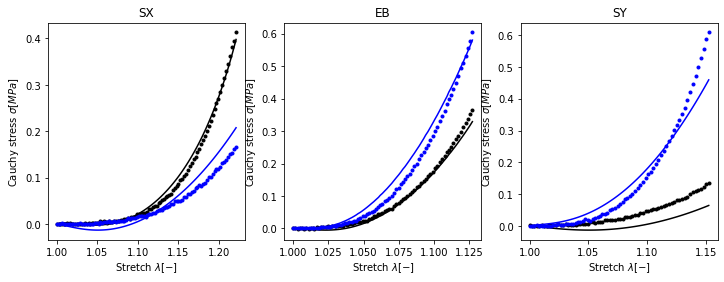

In [50]:
model = NODE_model(*params_a)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [9]:
# save the result with pickle
with open('savednet/NODE_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_a, f)

In [ ]:
params_e, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_e)
mdlnumber = 3
params_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

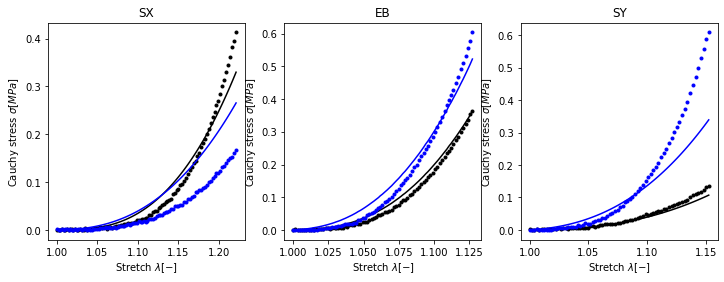

In [11]:
model = NODE_model(*params_e)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [12]:
# save the result with pickle
with open('savednet/NODE_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_e, f)

In [13]:
key, subkey = random.split(key)
params_sx, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_sx)
mdlnumber = 3
params_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 6.579089e-03
it 2000, train loss = 4.183121e-03
it 3000, train loss = 2.551888e-03
it 4000, train loss = 1.596597e-03
it 5000, train loss = 1.094942e-03
it 6000, train loss = 8.178257e-04
it 7000, train loss = 6.497893e-04
it 8000, train loss = 5.385468e-04
it 9000, train loss = 1.363250e-04
it 10000, train loss = 2.996606e-05
it 11000, train loss = 2.919461e-05
it 12000, train loss = 2.821131e-05
it 13000, train loss = 2.693585e-05
it 14000, train loss = 2.535564e-05
it 15000, train loss = 2.364010e-05
it 16000, train loss = 2.205629e-05
it 17000, train loss = 2.095093e-05
it 18000, train loss = 2.042406e-05
it 19000, train loss = 2.018914e-05
it 20000, train loss = 2.002968e-05
it 21000, train loss = 1.991938e-05
it 22000, train loss = 1.983077e-05
it 23000, train loss = 1.975601e-05
it 24000, train loss = 1.969025e-05
it 25000, train loss = 1.963048e-05
it 26000, train loss = 1.957446e-05
it 27000, train loss = 1.953921e-05
it 28000, train loss = 1.947073e-05
i

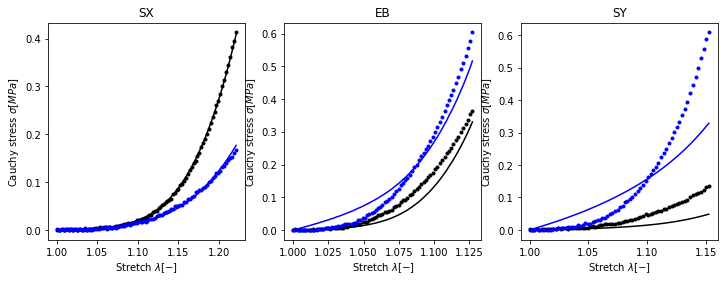

In [14]:
model = NODE_model(*params_sx)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [15]:
# save the result with pickle
with open('savednet/NODE_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_sx, f)

In [16]:
key, subkey = random.split(key)
params_sy, key = init_node(key)
opt_init, opt_update, get_params = optimizers.adam(1.e-4) #Original: 1.e-4
opt_state = opt_init(params_sy)
mdlnumber = 3
params_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 8.016264e-03
it 2000, train loss = 3.156428e-03
it 3000, train loss = 2.303291e-03
it 4000, train loss = 1.809647e-03
it 5000, train loss = 1.539317e-03
it 6000, train loss = 1.400142e-03
it 7000, train loss = 1.322251e-03
it 8000, train loss = 1.277149e-03
it 9000, train loss = 1.249277e-03
it 10000, train loss = 1.230820e-03
it 11000, train loss = 1.217974e-03
it 12000, train loss = 1.208121e-03
it 13000, train loss = 1.199775e-03
it 14000, train loss = 1.192305e-03
it 15000, train loss = 1.184862e-03
it 16000, train loss = 1.174688e-03
it 17000, train loss = 1.124561e-03
it 18000, train loss = 3.023824e-04
it 19000, train loss = 1.321670e-04
it 20000, train loss = 1.227657e-04
it 21000, train loss = 1.017308e-04
it 22000, train loss = 8.826293e-05
it 23000, train loss = 8.324537e-05
it 24000, train loss = 7.819490e-05
it 25000, train loss = 7.047278e-05
it 26000, train loss = 6.167492e-05
it 27000, train loss = 5.753415e-05
it 28000, train loss = 5.332102e-05
i

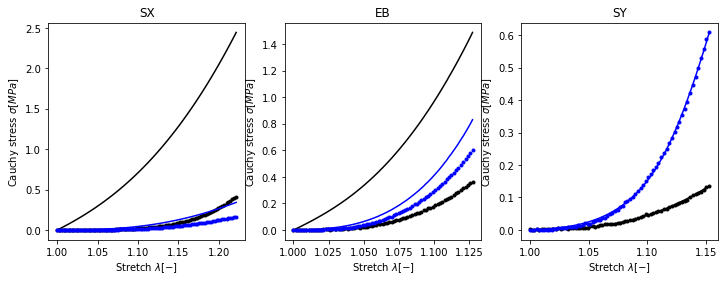

In [17]:
model = NODE_model(*params_sy)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [18]:
# save the result with pickle
with open('savednet/NODE_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_sy, f)

## Train ICNN

In [19]:
params_icnn_all, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_all)
mdlnumber = 2
params_icnn_all, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 100000) #Original 100000

it 1000, train loss = 1.460725e+00
it 2000, train loss = 6.043566e-01
it 3000, train loss = 4.657343e-01
it 4000, train loss = 3.604911e-01
it 5000, train loss = 2.795707e-01
it 6000, train loss = 2.167537e-01
it 7000, train loss = 1.677824e-01
it 8000, train loss = 1.287585e-01
it 9000, train loss = 9.285394e-02
it 10000, train loss = 7.040691e-02
it 11000, train loss = 5.746672e-02
it 12000, train loss = 4.657830e-02
it 13000, train loss = 3.779643e-02
it 14000, train loss = 3.090809e-02
it 15000, train loss = 2.559079e-02
it 16000, train loss = 2.151793e-02
it 17000, train loss = 1.840544e-02
it 18000, train loss = 1.602423e-02
it 19000, train loss = 1.419526e-02
it 20000, train loss = 1.278075e-02
it 21000, train loss = 1.167869e-02
it 22000, train loss = 1.081883e-02
it 23000, train loss = 1.015121e-02
it 24000, train loss = 9.632322e-03
it 25000, train loss = 9.230725e-03
it 26000, train loss = 8.933384e-03
it 27000, train loss = 8.731458e-03
it 28000, train loss = 8.556205e-03
i

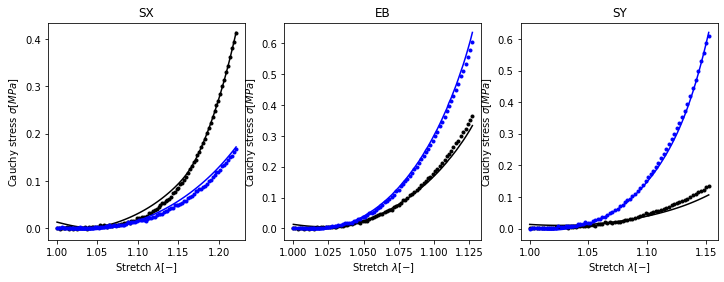

In [20]:
model = ICNN_model(*params_icnn_all)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [21]:
# save the result with pickle
with open('savednet/ICNN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_icnn_all, f)

In [22]:
params_icnn_e, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_e)
mdlnumber = 2
params_icnn_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.256378e+00
it 2000, train loss = 1.417852e+00
it 3000, train loss = 1.004361e+00
it 4000, train loss = 7.156523e-01
it 5000, train loss = 5.117581e-01
it 6000, train loss = 3.591083e-01
it 7000, train loss = 2.321357e-01
it 8000, train loss = 1.289851e-01
it 9000, train loss = 9.674273e-02
it 10000, train loss = 7.582663e-02
it 11000, train loss = 5.776618e-02
it 12000, train loss = 4.325891e-02
it 13000, train loss = 3.213436e-02
it 14000, train loss = 2.381212e-02
it 15000, train loss = 1.762853e-02
it 16000, train loss = 1.295443e-02
it 17000, train loss = 9.274044e-03
it 18000, train loss = 7.062872e-03
it 19000, train loss = 5.875309e-03
it 20000, train loss = 4.945514e-03
it 21000, train loss = 4.222026e-03
it 22000, train loss = 3.670244e-03
it 23000, train loss = 3.251599e-03
it 24000, train loss = 2.906423e-03
it 25000, train loss = 2.615381e-03
it 26000, train loss = 2.411994e-03
it 27000, train loss = 1.649565e-03
it 28000, train loss = 4.919061e-04
i

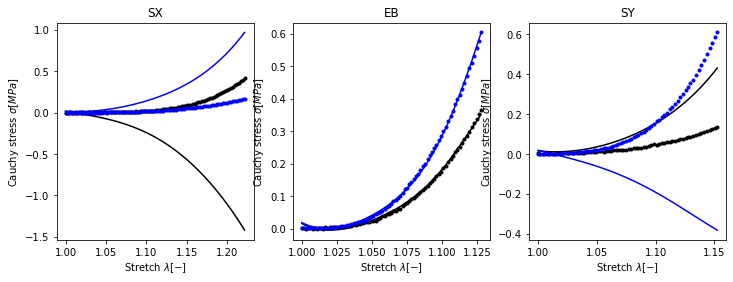

In [23]:
model = ICNN_model(*params_icnn_e)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [24]:
# save the result with pickle
with open('savednet/ICNN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_icnn_e, f)

In [25]:
params_icnn_sx, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sx)
mdlnumber = 2
params_icnn_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000)

it 1000, train loss = 2.571444e-01
it 2000, train loss = 1.481524e-01
it 3000, train loss = 1.186511e-01
it 4000, train loss = 9.230067e-02
it 5000, train loss = 6.962429e-02
it 6000, train loss = 5.090815e-02
it 7000, train loss = 3.520773e-02
it 8000, train loss = 2.102105e-02
it 9000, train loss = 1.119890e-02
it 10000, train loss = 8.282278e-03
it 11000, train loss = 6.584212e-03
it 12000, train loss = 5.094599e-03
it 13000, train loss = 3.851280e-03
it 14000, train loss = 2.858503e-03
it 15000, train loss = 2.072785e-03
it 16000, train loss = 1.413924e-03
it 17000, train loss = 8.846466e-04
it 18000, train loss = 5.680114e-04
it 19000, train loss = 3.978075e-04
it 20000, train loss = 2.940916e-04
it 21000, train loss = 2.219890e-04
it 22000, train loss = 1.679659e-04
it 23000, train loss = 1.264032e-04
it 24000, train loss = 9.456625e-05
it 25000, train loss = 7.038239e-05
it 26000, train loss = 5.220526e-05
it 27000, train loss = 3.877542e-05
it 28000, train loss = 2.894474e-05
i

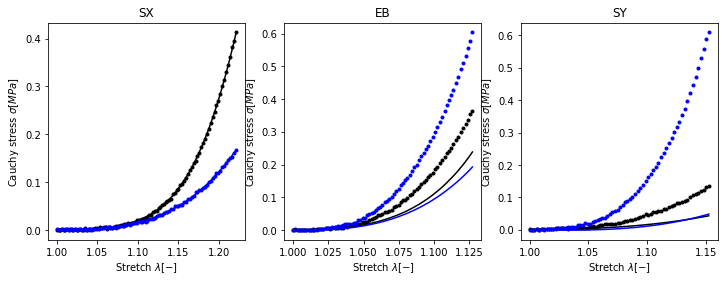

In [26]:
model = ICNN_model(*params_icnn_sx)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [27]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_icnn_sx, f)

In [28]:
params_icnn_sy, key = init_icnn(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sy)
mdlnumber = 2
params_icnn_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000)

it 1000, train loss = 1.175467e+00
it 2000, train loss = 5.651503e-01
it 3000, train loss = 3.952117e-01
it 4000, train loss = 2.935266e-01
it 5000, train loss = 2.224557e-01
it 6000, train loss = 1.703572e-01
it 7000, train loss = 1.310700e-01
it 8000, train loss = 9.975499e-02
it 9000, train loss = 6.851068e-02
it 10000, train loss = 3.470462e-02
it 11000, train loss = 2.575310e-02
it 12000, train loss = 2.137817e-02
it 13000, train loss = 1.747775e-02
it 14000, train loss = 1.414731e-02
it 15000, train loss = 1.142099e-02
it 16000, train loss = 9.242737e-03
it 17000, train loss = 7.514853e-03
it 18000, train loss = 6.143156e-03
it 19000, train loss = 5.074774e-03
it 20000, train loss = 4.248196e-03
it 21000, train loss = 3.609876e-03
it 22000, train loss = 3.116232e-03
it 23000, train loss = 2.732961e-03
it 24000, train loss = 2.434863e-03
it 25000, train loss = 2.203756e-03
it 26000, train loss = 2.025216e-03
it 27000, train loss = 1.883419e-03
it 28000, train loss = 1.250878e-03
i

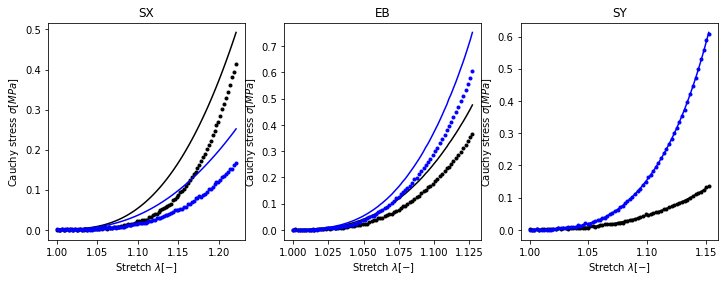

In [29]:
model = ICNN_model(*params_icnn_sy)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [30]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_icnn_sy, f)

## CANN training

In [31]:
params_cann_all, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_all)
mdlnumber = 1
params_cann_all, train_loss, val_loss = train_jp(loss_sig_all, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 4.970050e-03
it 2000, train loss = 1.193154e-03
it 3000, train loss = 8.418849e-04
it 4000, train loss = 5.785039e-04
it 5000, train loss = 4.635984e-04
it 6000, train loss = 4.323814e-04
it 7000, train loss = 4.135518e-04
it 8000, train loss = 3.921679e-04
it 9000, train loss = 3.253269e-04
it 10000, train loss = 2.966688e-04
it 11000, train loss = 2.849934e-04
it 12000, train loss = 2.777373e-04
it 13000, train loss = 2.718367e-04
it 14000, train loss = 2.665277e-04
it 15000, train loss = 2.615781e-04
it 16000, train loss = 2.568113e-04
it 17000, train loss = 2.520573e-04
it 18000, train loss = 2.472629e-04
it 19000, train loss = 2.423335e-04
it 20000, train loss = 2.372857e-04
it 21000, train loss = 2.322725e-04
it 22000, train loss = 2.274944e-04
it 23000, train loss = 2.228948e-04
it 24000, train loss = 2.188368e-04
it 25000, train loss = 2.150730e-04
it 26000, train loss = 2.120785e-04
it 27000, train loss = 2.098309e-04
it 28000, train loss = 2.075330e-04
i

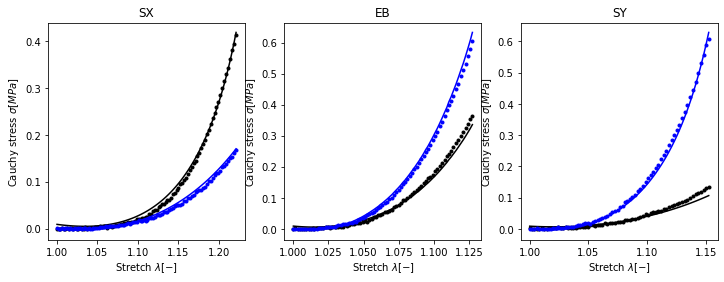

In [32]:
model = CANN_model(*params_cann_all)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [33]:
with open('savednet/CANN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_cann_all, f)

In [43]:
params_cann_e, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_e)
mdlnumber = 1
params_cann_e, train_loss, val_loss = train_jp(loss_sig_e, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 4.269715e-01
it 2000, train loss = 2.628041e-01
it 3000, train loss = 1.331672e-01
it 4000, train loss = 5.432511e-02
it 5000, train loss = 3.665291e-02
it 6000, train loss = 2.553531e-02
it 7000, train loss = 1.704239e-02
it 8000, train loss = 1.099994e-02
it 9000, train loss = 6.541911e-03
it 10000, train loss = 3.599569e-03
it 11000, train loss = 2.449006e-03
it 12000, train loss = 1.549855e-03
it 13000, train loss = 7.324044e-04
it 14000, train loss = 3.803892e-04
it 15000, train loss = 2.050118e-04
it 16000, train loss = 1.129386e-04
it 17000, train loss = 7.114997e-05
it 18000, train loss = 5.399584e-05
it 19000, train loss = 4.584131e-05
it 20000, train loss = 4.127217e-05
it 21000, train loss = 3.843194e-05
it 22000, train loss = 3.640719e-05
it 23000, train loss = 3.479519e-05
it 24000, train loss = 3.339099e-05
it 25000, train loss = 3.211310e-05
it 26000, train loss = 3.089851e-05
it 27000, train loss = 2.972710e-05
it 28000, train loss = 2.851098e-05
i

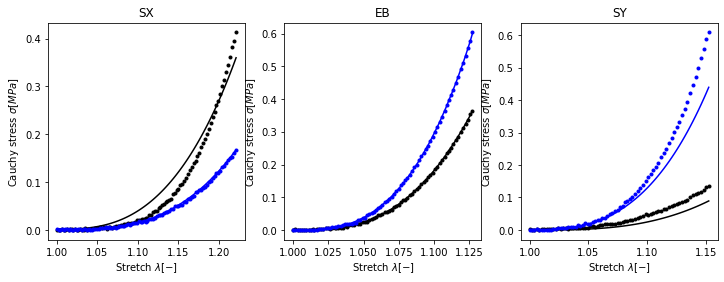

In [35]:
model = CANN_model(*params_cann_e)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [36]:
with open('savednet/CANN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_cann_e, f)

In [37]:
params_cann_sx, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sx)
mdlnumber = 1
params_cann_sx, train_loss, val_loss = train_jp(loss_sig_sx, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.075826e-03
it 2000, train loss = 9.877051e-05
it 3000, train loss = 7.598250e-05
it 4000, train loss = 4.776620e-05
it 5000, train loss = 3.253229e-05
it 6000, train loss = 2.349694e-05
it 7000, train loss = 1.797249e-05
it 8000, train loss = 1.510467e-05
it 9000, train loss = 1.330883e-05
it 10000, train loss = 1.153220e-05
it 11000, train loss = 9.573922e-06
it 12000, train loss = 8.096223e-06
it 13000, train loss = 6.989242e-06
it 14000, train loss = 6.237703e-06
it 15000, train loss = 5.946616e-06
it 16000, train loss = 5.673303e-06
it 17000, train loss = 5.439534e-06
it 18000, train loss = 5.269575e-06
it 19000, train loss = 5.172312e-06
it 20000, train loss = 5.137884e-06
it 21000, train loss = 5.127066e-06
it 22000, train loss = 5.121286e-06
it 23000, train loss = 5.111324e-06
it 24000, train loss = 5.100436e-06
it 25000, train loss = 5.089672e-06
it 26000, train loss = 5.079444e-06
it 27000, train loss = 5.069830e-06
it 28000, train loss = 5.060806e-06
i

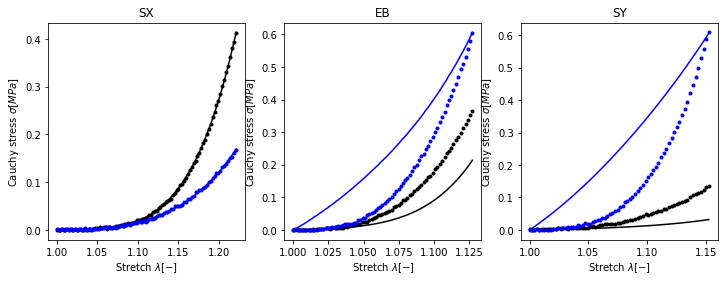

In [38]:
model = CANN_model(*params_cann_sx)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [39]:
with open('savednet/CANN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_cann_sx, f)

In [40]:
params_cann_sy, key = init_cann(key)
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sy)
mdlnumber = 1
params_cann_sy, train_loss, val_loss = train_jp(loss_sig_sy, mdlnumber, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 6.698598e-01
it 2000, train loss = 3.459087e-01
it 3000, train loss = 1.911524e-01
it 4000, train loss = 8.046745e-02
it 5000, train loss = 3.191409e-02
it 6000, train loss = 2.092755e-02
it 7000, train loss = 1.432082e-02
it 8000, train loss = 9.609427e-03
it 9000, train loss = 6.205801e-03
it 10000, train loss = 3.779819e-03
it 11000, train loss = 2.146161e-03
it 12000, train loss = 1.257789e-03
it 13000, train loss = 8.499922e-04
it 14000, train loss = 6.125317e-04
it 15000, train loss = 4.367318e-04
it 16000, train loss = 2.680622e-04
it 17000, train loss = 1.396586e-04
it 18000, train loss = 6.580775e-05
it 19000, train loss = 2.765267e-05
it 20000, train loss = 1.772458e-05
it 21000, train loss = 1.376384e-05
it 22000, train loss = 1.187344e-05
it 23000, train loss = 1.087520e-05
it 24000, train loss = 1.030293e-05
it 25000, train loss = 9.944752e-06
it 26000, train loss = 9.700161e-06
it 27000, train loss = 9.520327e-06
it 28000, train loss = 9.378544e-06
i

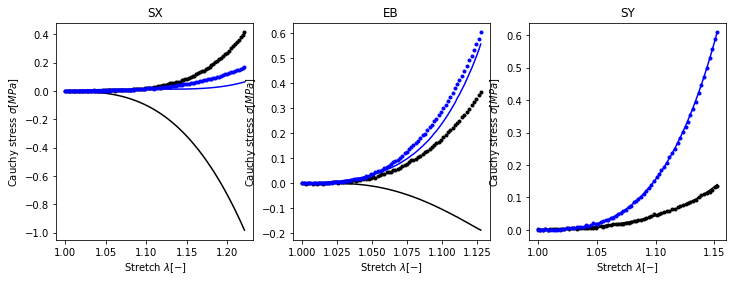

In [41]:
model = CANN_model(*params_cann_sy)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model)

fig, ax = plotstresses([lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigmax[ind_sx:ind_sy], sigmax[0:ind_sx], sigmax[ind_sy:]],
                       [sigmay[ind_sx:ind_sy], sigmay[0:ind_sx], sigmay[ind_sy:]],
                       [lambx[ind_sx:ind_sy], lambx[0:ind_sx], lamby[ind_sy:]],
                       [sigx[ind_sx:ind_sy], sigx[0:ind_sx], sigx[ind_sy:]],
                       [sigy[ind_sx:ind_sy], sigy[0:ind_sx], sigy[ind_sy:]])

In [42]:
with open('savednet/CANN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_cann_sy, f)

# Plot everything

In [57]:
with open('savednet/NODE_skinparams_all.npy', 'rb') as f:
    node_params_a = pickle.load(f)
with open('savednet/NODE_skinparams_equi.npy', 'rb') as f:
    node_params_e = pickle.load(f)
with open('savednet/NODE_skinparams_sx.npy', 'rb') as f:
    node_params_sx = pickle.load(f)
with open('savednet/NODE_skinparams_sy.npy', 'rb') as f:
    node_params_sy = pickle.load(f)

with open('savednet/ICNN_skinparams_all.npy', 'rb') as f:
    icnn_params_a = pickle.load(f)
with open('savednet/ICNN_skinparams_equi.npy', 'rb') as f:
    icnn_params_e = pickle.load(f)
with open('savednet/ICNN_skinparams_sx.npy', 'rb') as f:
    icnn_params_sx = pickle.load(f)
with open('savednet/ICNN_skinparams_sy.npy', 'rb') as f:
    icnn_params_sy = pickle.load(f)

with open('savednet/CANN_skinparams_all.npy', 'rb') as f:
    cann_params_a = pickle.load(f)
with open('savednet/CANN_skinparams_equi.npy', 'rb') as f:
    cann_params_e = pickle.load(f)
with open('savednet/CANN_skinparams_sx.npy', 'rb') as f:
    cann_params_sx = pickle.load(f)
with open('savednet/CANN_skinparams_sy.npy', 'rb') as f:
    cann_params_sy = pickle.load(f)

with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb_sigma = np.hstack([lamb,sigma])
ind_sx = 81
ind_sy = 182

I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

params_sx = [cann_params_sx, icnn_params_sx, node_params_sx]
params_e = [cann_params_e, icnn_params_e, node_params_e]
params_sy = [cann_params_sy, icnn_params_sy, node_params_sy]
params_a = [cann_params_a, icnn_params_a, node_params_a]
params_list = [params_sx, params_e, params_sy, params_a]

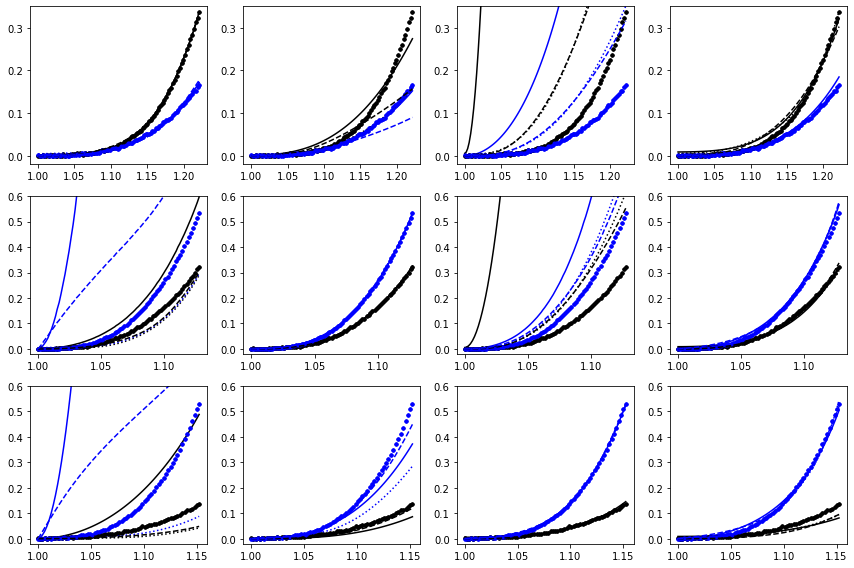

In [58]:
fig, axes = plt.subplots(3,4,figsize=(12,8))
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
panels_list = [['a', 'e', 'i'], ['b', 'f', 'j'], ['c', 'g', 'k'], ['d', 'h', 'l']]

for ax, params, panels in zip(axes.T, params_list, panels_list):
    params_cann, params_icnn, params_node = params

    cann_model = CANN_model(*params_cann, normalization)
    icnn_model = ICNN_model(*params_icnn, normalization)
    node_model = NODE_model(*params_node, normalization)

    models = [cann_model, icnn_model, node_model]
    plotstyles = ['-', ':', '--']
    modelnames = ['CANN', 'ICNN', 'NODE']

    for model, modelname, style in zip(models, modelnames, plotstyles):
        indices = [[ind_sx,ind_sy], [0, ind_sx], [ind_sy,lamb.shape[0]]]
        whichlambda = [0,0,1] #because we need to plot strip-y wrt lm_y and the rest wrt lm_x

        sgm_x_pr, sgm_y_pr = eval_Cauchy(lambx, lamby, model, normalization)
        P_x_pr = sgm_x_pr/lambx
        P_y_pr = sgm_y_pr/lamby
        P_x_gt = lamb_sigma[:,2]/lambx
        P_y_gt = lamb_sigma[:,3]/lamby
        ylims = [[-0.020,0.35],[-0.020,0.6],[-0.020,0.6]]
        for axi, (i1,i2), lmid, ylim, panel in zip(ax,indices, whichlambda, ylims, panels):
            lm = lamb_sigma[i1:i2,lmid]
            axi.plot(lm, P_x_gt[i1:i2],'k.',label='$P_x$ Exp.')
            axi.plot(lm, P_y_gt[i1:i2],'b.',label='$P_y$ Exp.')

            axi.plot(lm, P_x_pr[i1:i2],'k'+style, label='$P_x$ '+modelname)
            axi.plot(lm, P_y_pr[i1:i2],'b'+style, label='$P_y$ '+modelname)

            axi.set(ylim=ylim)

            # Save for TikZ
            data = np.array([lm, P_x_gt[i1:i2], P_y_gt[i1:i2]]).T
            columns = ['x', 'P_x_gt', 'P_y_gt']
            df = pd.DataFrame(data, columns = columns)
            df.to_csv('TikZ/fig_skin1_data/data'+'_'+panel+'.csv', index=False, sep=' ')

            data = np.array([lm, P_x_pr[i1:i2], P_y_pr[i1:i2]]).T
            columns = ['x', 'P_x_pr', 'P_y_pr']
            df = pd.DataFrame(data, columns = columns)
            df.to_csv('TikZ/fig_skin1_data/'+modelname+'_'+panel+'.csv', index=False, sep=' ')
# axes[0,0].legend()
fig.tight_layout()
            

# 50 runs

In [10]:
cann_r2 = []
icnn_r2 = []
node_r2 = []
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
for i in range(10):
    print(i)
    mdlnumbers = [1,2,3]
    init_fns = [init_cann, init_icnn, init_node]
    MODELS = [CANN_model, ICNN_model, NODE_model]

    cann_r2i = []
    icnn_r2i = []
    node_r2i = []
    r2lists = [cann_r2i, icnn_r2i, node_r2i]

    for mdlnumber, init_fn, MODEL, r2list in zip(mdlnumbers, init_fns, MODELS, r2lists):
        for loss_fn in ([loss_sig_sx, loss_sig_e, loss_sig_sy, loss_sig_all]):
            key, subkey = random.split(key)
            params, key = init_fn(key)

            opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
            opt_state = opt_init(params)
            params, train_loss, val_loss = train_jp(loss_fn, mdlnumber, lamb_sigma, opt_state, key, nIter = 70000, print_freq=200000)

            #make predictions
            model = MODEL(*params, normalization)
            
            indices = [[ind_sx,ind_sy], [0, ind_sx], [ind_sy,lamb.shape[0]]]
            whichlambda = [0,0,1] #because we need to plot strip-y wrt lm_y and the rest wrt lm_x

            sgm_x_pr, sgm_y_pr = eval_Cauchy(lambx, lamby, model, normalization)
            P_x_pr = sgm_x_pr/lambx
            P_y_pr = sgm_y_pr/lamby
            P_x_gt = lamb_sigma[:,2]/lambx
            P_y_gt = lamb_sigma[:,3]/lamby
            for (i1,i2) in indices:
                r2_1 = r2_score(P_x_gt[i1:i2], P_x_pr[i1:i2])
                r2_2 = r2_score(P_y_gt[i1:i2], P_y_pr[i1:i2])
                r2 = 0.5*(r2_1+r2_2)
                r2list.append(r2)
    cann_r2.append(cann_r2i)
    icnn_r2.append(icnn_r2i)
    node_r2.append(node_r2i)

CANN_r2 = np.array(cann_r2)
ICNN_r2 = np.array(icnn_r2)
NODE_r2 = np.array(node_r2)
with open('savednet/CANN_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(CANN_r2, f)
with open('savednet/ICNN_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(ICNN_r2, f)
with open('savednet/NODE_skin_r2_alldata.npy', 'wb') as f:
    pickle.dump(NODE_r2, f)

0
1
2
3
4
5
6
7
8
9


In [11]:
CANN_r2 = np.clip(CANN_r2, a_min=0.0, a_max=1.0)
ICNN_r2 = np.clip(ICNN_r2, a_min=0.0, a_max=1.0)
NODE_r2 = np.clip(NODE_r2, a_min=0.0, a_max=1.0)

CANN_r2_mean = np.mean(CANN_r2,axis=0)
CANN_r2_stdv = np.std(CANN_r2,axis=0)

ICNN_r2_mean = np.mean(ICNN_r2,axis=0)
ICNN_r2_stdv = np.std(ICNN_r2,axis=0)

NODE_r2_mean = np.mean(NODE_r2,axis=0)
NODE_r2_stdv = np.std(NODE_r2,axis=0)

# Save for TikZ
xs = [0.0, 1.0, 2.0]
r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
names = ['CANN', 'ICNN', 'NODE']
for name, x, r2_mean, r2_stdv in zip(names, xs, r2_means, r2_stdvs):
    columns = ['x', 'a', 'e', 'i', 'b', 'f', 'j', 'c', 'g', 'k', 'd', 'h', 'l']
    data = np.expand_dims(np.hstack([x,r2_mean]),axis=0)
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_skinR2_data/'+name+'_mean.csv', index=False, sep = ' ')

    data1 = np.expand_dims(np.hstack([x,r2_mean-r2_stdv]),axis=0)
    data2 = np.expand_dims(np.hstack([x,r2_mean+r2_stdv]),axis=0)
    data = np.vstack([data1,data2])
    df = pd.DataFrame(data, columns=columns)
    df.to_csv('TikZ/fig_skinR2_data/'+name+'_stdv.csv', index=False, sep = ' ')

CANN_r2_mean = CANN_r2_mean.reshape([4,3]).T
CANN_r2_stdv = CANN_r2_stdv.reshape([4,3]).T
ICNN_r2_mean = ICNN_r2_mean.reshape([4,3]).T
ICNN_r2_stdv = ICNN_r2_stdv.reshape([4,3]).T
NODE_r2_mean = NODE_r2_mean.reshape([4,3]).T
NODE_r2_stdv = NODE_r2_stdv.reshape([4,3]).T

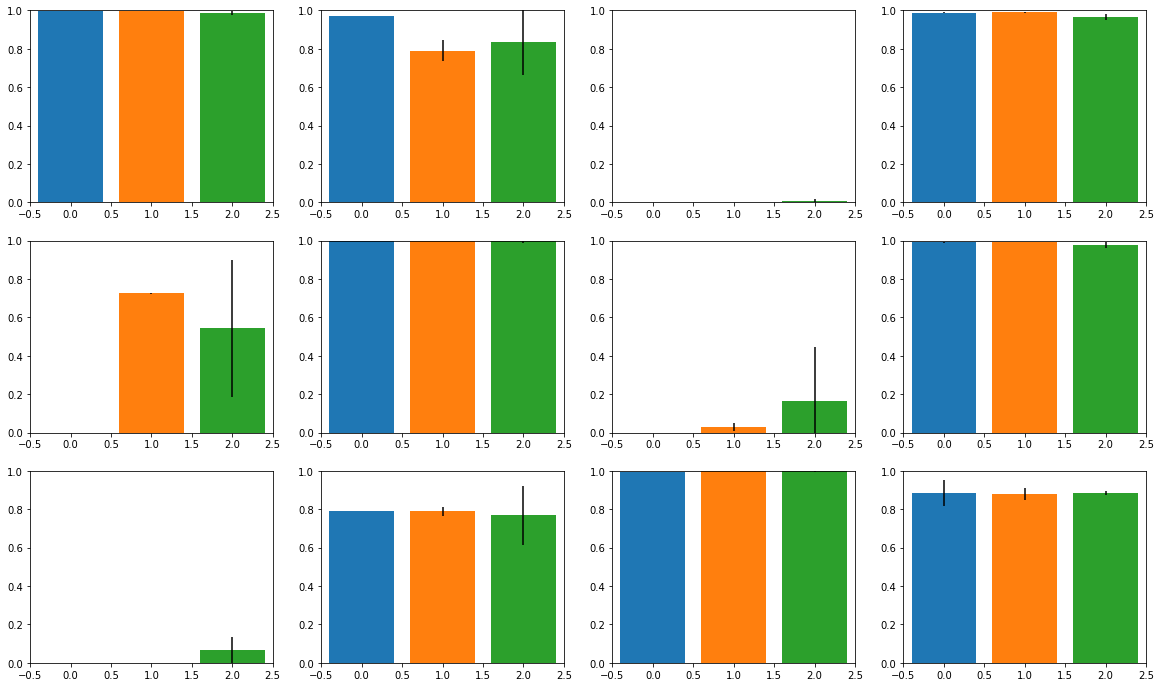

In [12]:
fig, axes = plt.subplots(3,4, figsize=(20,12))

r2_means = [CANN_r2_mean, ICNN_r2_mean, NODE_r2_mean]
r2_stdvs = [CANN_r2_stdv, ICNN_r2_stdv, NODE_r2_stdv]
for x, model_r2_mean, model_r2_stdv in zip(xs, r2_means, r2_stdvs):
    for ax, row_r2_mean, row_r2_stdv in zip(axes, model_r2_mean, model_r2_stdv):
        for axi, r2_mean, r2_stdv in zip(ax, row_r2_mean, row_r2_stdv):
            axi.bar(x, r2_mean)
            axi.errorbar(x, r2_mean, r2_stdv, color='black')
            axi.set(xlim=[-0.5,2.5], ylim=[0,1])

fig.savefig('Figures/fig_skin_R2.jpg')